# CNA Data
---

In [1]:
# Import necessary libraries
from IPython.display import Markdown
import datetime
from datetime import date
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itables import init_notebook_mode, show
import itables.options as opt
import warnings

# Initialize itables options
opt.dom = "tpir"
opt.style = "table-layout:auto;width:auto"
init_notebook_mode(all_interactive=True, connected=True)

# Configure warnings
warnings.filterwarnings("ignore")

# Configure pandas display options
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)


In [2]:
def get_nested_value(entry, keys, default='Missing_Data'):
    try:
        for key in keys:
            entry = entry[key]
        return entry
    except (KeyError, IndexError):
        return default

row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            new_row = {
                'CVE': get_nested_value(entry, ['cve', 'id']),
                'Published': get_nested_value(entry, ['cve', 'published']),
                'AttackVector': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackVector']),
                'AttackComplexity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackComplexity']),
                'PrivilegesRequired': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'privilegesRequired']),
                'UserInteraction': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'userInteraction']),
                'Scope': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'scope']),
                'ConfidentialityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'confidentialityImpact']),
                'IntegrityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'integrityImpact']),
                'AvailabilityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'availabilityImpact']),
                'BaseScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseScore'], '0.0'),
                'BaseSeverity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseSeverity']),
                'ExploitabilityScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'exploitabilityScore']),
                'ImpactScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'impactScore']),
                'CWE': get_nested_value(entry, ['cve', 'weaknesses', 0, 'description', 0, 'value']),
                'Description': get_nested_value(entry, ['cve', 'descriptions', 0, 'value'], ''),
                'Assigner': get_nested_value(entry, ['cve', 'sourceIdentifier']),
                'Tag': get_nested_value(entry, ['cve', 'cveTags', 0, 'tags'], np.nan),
                'Status': get_nested_value(entry, ['cve', 'vulnStatus'], '')
            }
            row_accumulator.append(new_row)

nvd = pd.DataFrame(row_accumulator)
nvd = nvd[~nvd.Status.str.contains('Rejected')]
nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan);
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
startdate = date(2000, 1, 1)
enddate  = date.today()
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days

## CNA Assigner Graphs

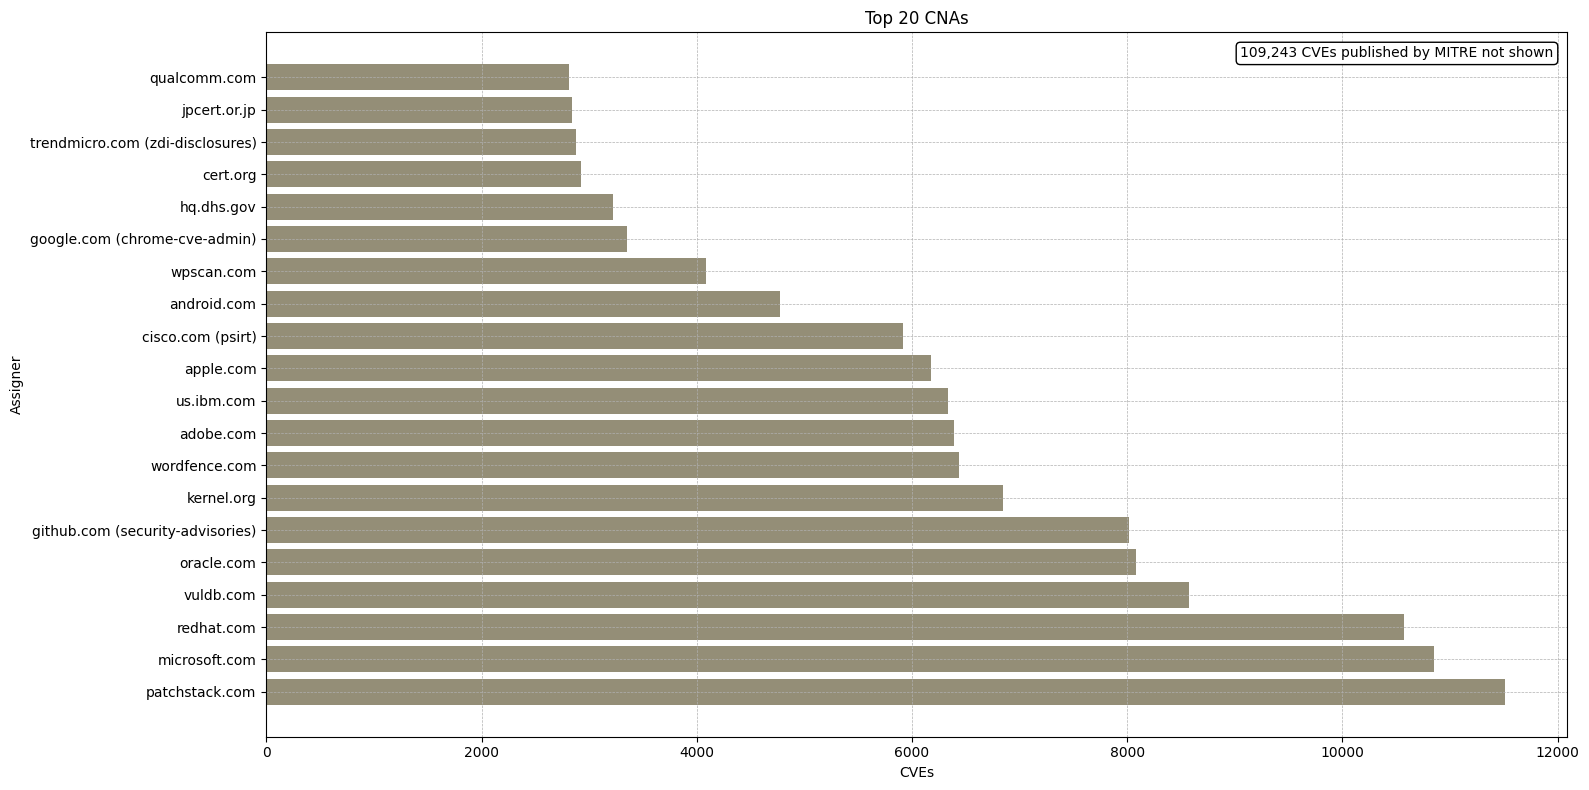

In [3]:
# Replace specific assigner ID with email
nvd['Assigner'].replace('416baaa9-dc9f-4396-8d5f-8c081fb06d67', 'cve@kernel.org', inplace=True)

# Extract domain names and check for uniqueness
nvd['Domain'] = nvd['Assigner'].apply(lambda x: x.split('@')[-1])
domain_counts = nvd['Domain'].value_counts()

# Modify Assigner column based on domain uniqueness
unique_domains = nvd.groupby('Domain')['Assigner'].nunique()
nvd['Assigner'] = nvd.apply(lambda x: x['Domain'] if unique_domains[x['Domain']] == 1 else f"{x['Domain']} ({x['Assigner'].split('@')[0]})", axis=1)

# Calculate frequency of assigners
nvd_frequency = nvd['Assigner'].value_counts().reset_index()
nvd_frequency.columns = ['Assigner', 'counts']
nvd_frequency = nvd_frequency[nvd_frequency.counts > 100].head(50)

# Calculate the number of CVEs published by mitre.org
mitre_cves = nvd_frequency[nvd_frequency['Assigner'].str.contains('mitre.org')]['counts'].sum()

# Remove mitre.org from the frequency list
nvd_frequency_no_mitre = nvd_frequency[~nvd_frequency.Assigner.str.contains('mitre.org')]
nvd_frequency_no_mitre = nvd_frequency_no_mitre[nvd_frequency_no_mitre.counts > 100].head(20)

# Plot the top 20 CNAs
plt.figure(figsize=(16, 8))
plt.barh("Assigner", "counts", data=nvd_frequency_no_mitre, color=plt.get_cmap('cividis')(0.6))
plt.xlabel("CVEs")
plt.ylabel("Assigner")
plt.title("Top 20 CNAs")
plt.grid(True, linestyle='--', linewidth=0.5)

# Add a text box indicating mitre.org has been removed and the number of CVEs they published
textstr = f'{mitre_cves:,} CVEs published by MITRE not shown'
plt.text(0.99, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

# Adjust layout and show the chart
plt.tight_layout()
plt.show()

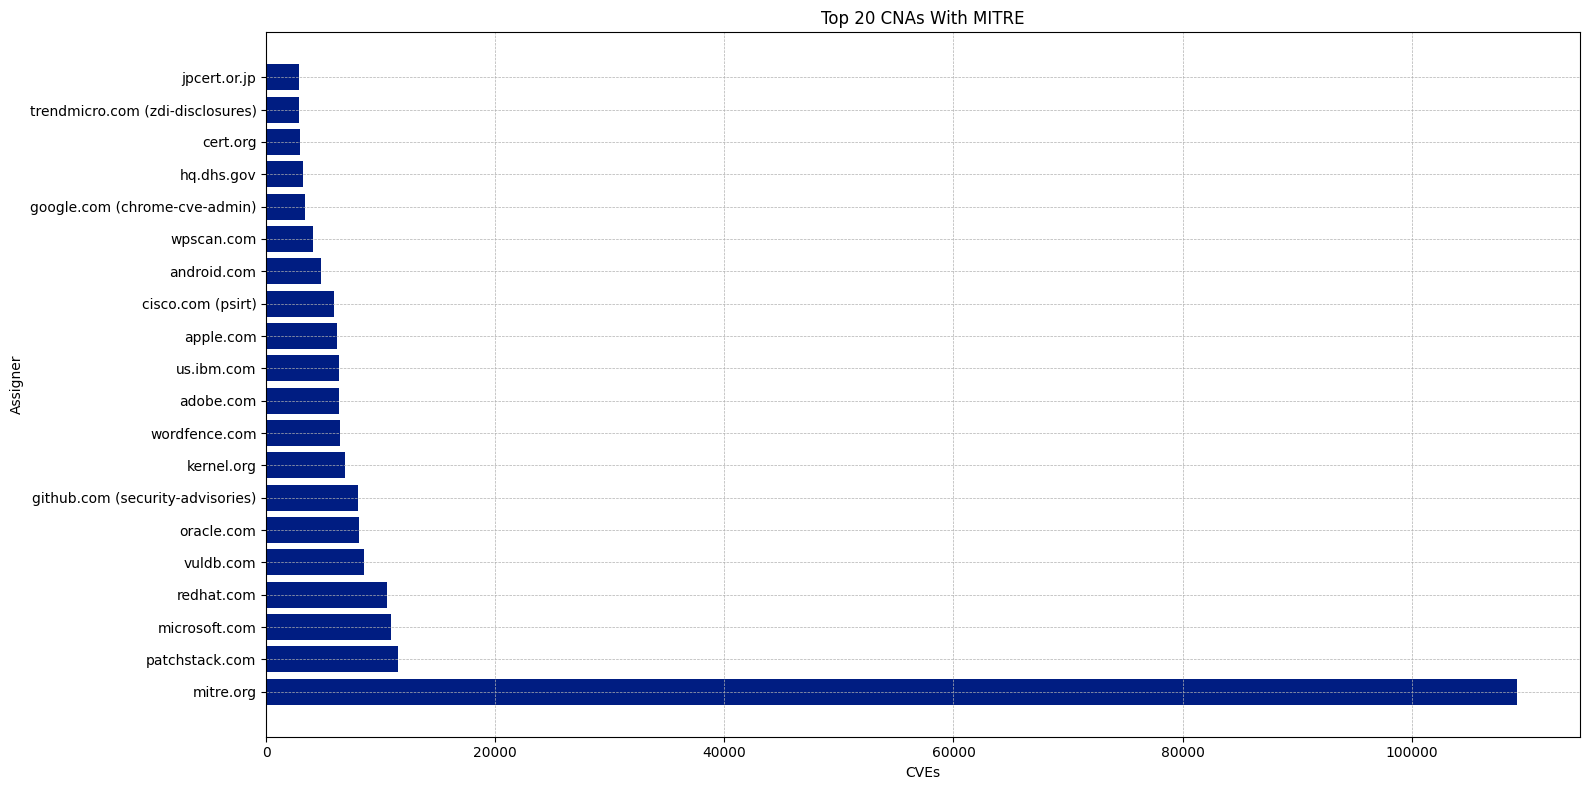

In [4]:
import matplotlib.pyplot as plt

# Replace specific assigner ID with email
nvd['Assigner'].replace('416baaa9-dc9f-4396-8d5f-8c081fb06d67', 'cve@kernel.org', inplace=True)

# Extract domain names and check for uniqueness
nvd['Domain'] = nvd['Assigner'].apply(lambda x: x.split('@')[-1])
domain_counts = nvd['Domain'].value_counts()

# Modify Assigner column based on domain uniqueness
unique_domains = nvd.groupby('Domain')['Assigner'].nunique()
nvd['Assigner'] = nvd.apply(lambda x: x['Domain'] if unique_domains[x['Domain']] == 1 else f"{x['Domain']} ({x['Assigner'].split('@')[0]})", axis=1)

# Calculate frequency of assigners
nvd_frequency = nvd['Assigner'].value_counts().reset_index()
nvd_frequency.columns = ['Assigner', 'counts']
nvd_frequency = nvd_frequency[nvd_frequency.counts > 100].head(50)

# Plot the top 20 CNAs including MITRE
plt.figure(figsize=(16, 8))
plt.barh("Assigner", "counts", data=nvd_frequency.head(20), color="#001d82")
plt.xlabel("CVEs")
plt.ylabel("Assigner")
plt.title("Top 20 CNAs With MITRE")
plt.grid(True, linestyle='--', linewidth=0.5)

# Adjust layout and show the chart
plt.tight_layout()
plt.show()

## Top CVE Assigners

In [5]:
import matplotlib.pyplot as plt

# Replace specific assigner ID with email
nvd['Assigner'].replace('416baaa9-dc9f-4396-8d5f-8c081fb06d67', 'cve@kernel.org', inplace=True)

# Extract domain names and check for uniqueness
nvd['Domain'] = nvd['Assigner'].apply(lambda x: x.split('@')[-1])
domain_counts = nvd['Domain'].value_counts()

# Modify Assigner column based on domain uniqueness
unique_domains = nvd.groupby('Domain')['Assigner'].nunique()
nvd['Assigner'] = nvd.apply(lambda x: x['Domain'] if unique_domains[x['Domain']] == 1 else f"{x['Domain']} ({x['Assigner'].split('@')[0]})", axis=1)

# Calculate frequency of assigners
nvd_frequency = nvd['Assigner'].value_counts().reset_index()
nvd_frequency.columns = ['Assigner', 'counts']

show(nvd_frequency, scrollCollapse=True, paging=True)

Loading ITables v2.4.3 from the internet... (need help?)


In [6]:
Markdown(f"This report is updated automatically every day, last generated on: **{datetime.datetime.now()}**")

This report is updated automatically every day, last generated on: **2025-07-02 16:16:33.073721**